In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import load
from joblib import load as jload
from sklearn.metrics import roc_curve, auc, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')    

# Running Models on Data

This notebook is for running all of the models we generated that were not in R (i.e. all models except for the LASSO models). To use the primary model reported in our paper, use `run_LASSO.r`. 

Here we use our simulated data generated in `generate_simulated_data.ipynb` but one could load and use their own data if they format their data to match.

In [2]:
def scale_data(X_test):    
    
    # checks for right data shape
    if X_test.shape[1] != 759:
        print(f"Wrong number of features. Expecting 759. Got {X_test.shape[1]}.")
    
    # loads the scaler trained on our data
    with open('../utilities/scaler.pkl', 'rb') as pickle_file:
        scaler = load(pickle_file)
    pickle_file.close() 
    
    # train the data
    X_test = scaler.transform(X_test)
    
    return X_test

def bootstrap(df, outcome):
    # runs 1000 fold bootstrap to determine 95% confidence intervals
    aucs = []
    for i in range(1000):
        sample = df.sample(n=df.shape[0] -
                           int(df.shape[0] / 5))  #take 80% for the bootstrap
        aucs.append(roc_auc_score(sample[outcome], sample["predictions"]))

    return np.percentile(np.array(aucs),50), np.percentile(np.array(aucs),
                         2.5), np.percentile(np.array(aucs), 97.5)

In [3]:
# load our data and labels (change to your own path, if using your own data)
data_path = "../data/simulated_data/simulated_feature_matrix.csv"
outcome_path = "../data/simulated_data/simulated_outcomes.csv"
outcome = "ANY_180"

data = pd.read_csv(data_path).drop("DEMO_NON_PALLIATIVE",axis=1)
outcomes = pd.read_csv(outcome_path)

In [4]:
# scale the data for preprocessing
X = scale_data(data.set_index("PAT_DEID"))

In [5]:
model_path = "../models/rf_any_180.joblib"

# loads the model trained on our data
with open(model_path, 'rb') as pickle_file:
    model = jload(pickle_file)
    
# make predictions
predictions = model.predict(X)
predictions_prob = model.predict_proba(X)[:,1]

# add these to the simulated labels to compare
outcomes["Class predictions"] = predictions
outcomes["predictions"] = predictions_prob
outcomes.head()

,PAT_DEID,ANY_180,Class predictions,predictions
0,1533957,0,True,0.515
1,2380316,1,True,0.525
2,3020815,1,True,0.526
3,3083237,1,False,0.472
4,209372,0,True,0.540


In [6]:
# calculate the AUROC's CIs via bootstrap
# as expected with random data, we do not have accurate predictions
mean, ci_low, ci_high = bootstrap(outcomes, outcome)
print(f'AUROC is: {round(mean,3)}, 95% CI: [{round(ci_low,3)}-{round(ci_high,3)}]')

AUROC is: 0.518, 95% CI: [0.457-0.578]


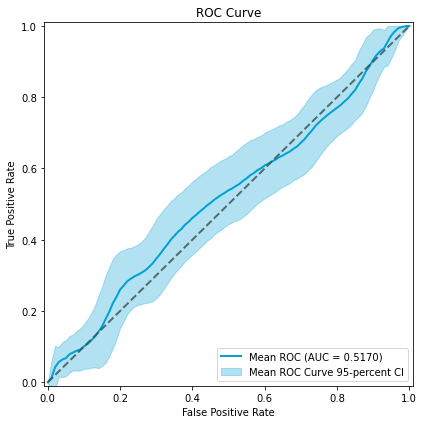

In [7]:
# plot the ROC curve
base_fpr = np.linspace(0, 1, 101)

## TEST ON 80% of TESTING DATA 1000x, GATHER MEAN/SD OF ROC-CURVE POINTS
tprs = []
aucs = []
for i in range(1000):
    #take 80% for the bootstrap
    sample = outcomes.sample(n=outcomes.shape[0] -
                       int(outcomes.shape[0] / 5))  
    fpr, tpr, _ = roc_curve(sample["ANY_180"], sample["predictions"])
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

# calculate some statistics on the curve
tprs1 = np.array(tprs)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)
mean_auc1 = auc(base_fpr, mean_tprs1)
std_auc1 = np.std(aucs)

# find our upper and lower CIs for plotting
tprs_upper1 = np.minimum(mean_tprs1 + 1.96*std1, 1)
tprs_lower1 = mean_tprs1 - 1.96*std1

# plot it
fig,axes = plt.subplots(figsize=(6,6))
axes.plot(base_fpr, mean_tprs1, lw=2, label=r'Mean ROC (AUC = %0.4f)' % (mean_auc1), color='#00A1D5FF')
axes.fill_between(base_fpr, tprs_lower1, tprs_upper1, alpha = 0.3,
                  label=r"Mean ROC Curve 95-percent CI" % (std_auc1), color='#00A1D5FF')
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color='#374E55FF', alpha= 0.8)
axes.set_xlim([-0.01, 1.01])
axes.set_ylim([-0.01, 1.01])
axes.set_ylabel('True Positive Rate')
axes.set_xlabel('False Positive Rate')
axes.legend(loc="lower right")
axes.set_title('ROC Curve')

plt.tight_layout()
plt.show()
plt.savefig('example.png')